# Classifiers to predict loan repayment based on historical data

### Import the data & preprocess

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Let's combine the TESTING & TRAINING datasets, shuffle & randomly split TRAINING & TESTING datasets (idea is to cleanup the data just one one)

# Initialize the dataframes
df_trn = []
df_tst = []

# Copy the training & testing datasets
df_trn = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv')
df_tst = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv')

df_tot = pd.concat([df_trn, df_tst]) 

# CONVERT DATETIME 
df_tot['due_date'] = pd.to_datetime(df_tot['due_date'])
df_tot['effective_date'] = pd.to_datetime(df_tot['effective_date'])

print("Dimensions of the concatenated DataFrame (rows, cols) is :", df_tot.shape)

df_tot.head()


Dimensions of the concatenated DataFrame (rows, cols) is : (400, 10)


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [2]:
# INSTALL seaborn PACKAGE
!conda install -c anaconda seaborn -y

Solving environment: ...working... done

# All requested packages already installed.



#### visualize the paidoff v collection info for Male & Female Genders, by age, loan amount & loan day of the week)

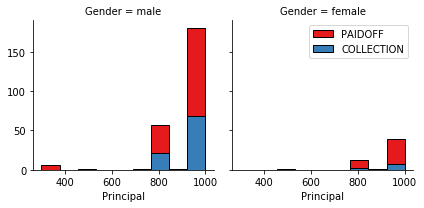

In [3]:
import seaborn as sns

bins = np.linspace(df_tot.Principal.min(), df_tot.Principal.max(), 10)
g = sns.FacetGrid(df_tot, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

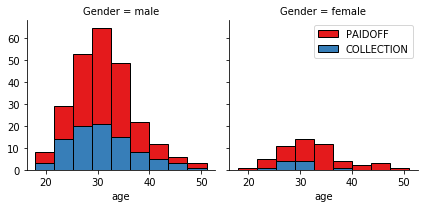

In [4]:
bins = np.linspace(df_tot.age.min(), df_tot.age.max(), 10)
g = sns.FacetGrid(df_tot, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

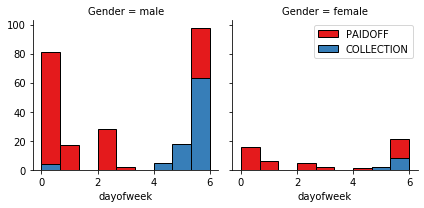

In [5]:
df_tot['dayofweek'] = df_tot['effective_date'].dt.dayofweek
bins = np.linspace(df_tot.dayofweek.min(), df_tot.dayofweek.max(), 10)
g = sns.FacetGrid(df_tot, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

### Create Training & Test Data for the Classifiers

In [6]:
# Engineer a feature column called dayofweek (loan date) evaluated based on 'effective_date'(0 thru 6 for Mon thru Sun)
df_tot['dayofweek'] = df_tot['effective_date'].dt.dayofweek

# Engineer another feature column called weekend, a binary value depending on weekday or a weekend day
df_tot['weekend'] = df_tot['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# Engineer the male & female features as 0 & 1 respectively (lends to boolean operations that are faster than string operations)
df_tot['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# Rename Columns appropriately
df_tot['education'].replace(to_replace=['High School or Below', 'college', 'Bechalor', 'Master or Above'], value=['GradeSchool', 'UnderGrad', 'Graduate', 'PostGrad'],inplace=True)

df_tot = pd.concat([df_tot, pd.get_dummies(df_tot['education'])], axis=1)

# Drop the unnecessary columns 
df_tot.drop(['Unnamed: 0', 'Unnamed: 0.1', 'education'], axis=1, inplace=True)

print(df_tot.head(3))


#######################################
# FEATURE SELECTION (X, Y)
#######################################

# Select the following 10 features as X (array) - categorical data is converted to numerical data as additional features
X = df_tot[['Principal','terms','age','Gender','dayofweek', 'weekend', 'GradeSchool', 'Graduate', 'PostGrad', 'UnderGrad']]
Y = df_tot['loan_status']


#######################################
# SPLIT THE TRAINING & TESTING DATASETS
#######################################

# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split the dataset as testing & training
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=0.2, random_state=4)

# Print the shape of the resulting datasets (dataframes)
print("\nThe shape (rows, cols) of the training dataset is ", X_trn.shape)
print("\nThe shape (rows, cols) of the testing  dataset is ", X_tst.shape)

print("\n The 10 features selected to create model are : \n", X_trn.head(3))
print("\n The dependent variable used to fit the model : \n", Y_trn.head(3))

  loan_status  Principal  terms effective_date   due_date  age  Gender  \
0     PAIDOFF       1000     30     2016-09-08 2016-10-07   45       0   
1     PAIDOFF       1000     30     2016-09-08 2016-10-07   33       1   
2     PAIDOFF       1000     15     2016-09-08 2016-09-22   27       0   

   dayofweek  weekend  GradeSchool  Graduate  PostGrad  UnderGrad  
0          3        0            1         0         0          0  
1          3        0            0         1         0          0  
2          3        0            0         0         0          1  

The shape (rows, cols) of the training dataset is  (320, 10)

The shape (rows, cols) of the testing  dataset is  (80, 10)

 The 10 features selected to create model are : 
      Principal  terms  age  Gender  dayofweek  weekend  GradeSchool  Graduate  \
153        300      7   29       0          0        0            1         0   
42        1000     30   35       1          6        1            0         1   
339       1000

### KNN - Build the model & make a prediction

In [289]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

#Train Model and Predict for n = 4 (just a guess)
modelKNN = KNeighborsClassifier(n_neighbors = 2).fit(X_trn, Y_trn)
Y_knn = modelKNN.predict(X_tst)

### KNN - Evaluate Accuracy of the model by varying 'K'

In [290]:
from sklearn import metrics

k = 10

#Initialize a numpy arrays with zeros, to store accuracy for clusters (k = 1 thru 9)
mean_accuracy = np.zeros((k-1))  #Mean of Accuracy
std_accuracy = np.zeros((k-1))   #Std Deviation of Accuracy


for n in range(1,k):
   
    # Train Model and Predict for each value of 'n'
    modelKNN = KNeighborsClassifier(n_neighbors = n).fit(X_trn, Y_trn)
    
    # Make the predictions 
    Y_knn = modelKNN.predict(X_tst)

    # Compute Mean & Standard Deviation of accuracy of predictions
    mean_accuracy[n-1] = metrics.accuracy_score(Y_tst, Y_knn)
  
    std_accuracy[n-1]=np.std(Y_knn==Y_tst)/np.sqrt(Y_tst.shape[0])


# Print the Mean Accuracy & the corresponding Standard Deviation of Accuracy for each 'k'
print("\n Mean   Accuracy for knn clusters, k ranging (1-9) : ", mean_accuracy)
print("\n StdDev Accuracy for knn clusters, k ranging (1-9) : ", std_accuracy)




 Mean   Accuracy for knn clusters, k ranging (1-9) :  [0.66 0.66 0.72 0.65 0.66 0.66 0.66 0.65 0.69]

 StdDev Accuracy for knn clusters, k ranging (1-9) :  [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]


### KNN - Evaluate the best value for 'K' & visualize


The best accuracy was with 0.725 with k= 3 




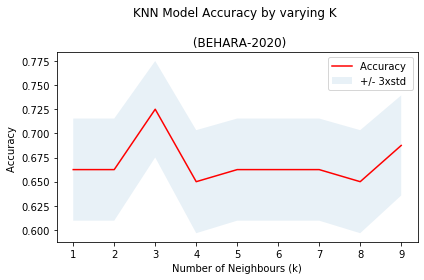

In [282]:
# Print to console the best accuracy acheived
print( "\nThe best accuracy was with", mean_accuracy.max(), "with k=", mean_accuracy.argmax()+1,"\n\n") 

# Visualize the accuracy
plt.plot(range(1,k),mean_accuracy,'r')
plt.fill_between(range(1,k),mean_accuracy - 1 * std_accuracy,mean_accuracy + 1 * std_accuracy, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (k)')
plt.title('KNN Model Accuracy by varying K \n\n (BEHARA-2020)')
plt.tight_layout()
plt.show()

### Decision Tree - Build the model & make predictions

In [291]:
# First import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Let's create an instance of the DecisionTreeClassifier called modelDecisionTree, 4 levels deep
# Inside of the classifier, specify criterion="entropy" so we can see the information gain of each node 
modelDTC = DecisionTreeClassifier(criterion="entropy", max_depth = 3)

# Print the model characteristics
print("The Decision Tree Model Parameters are : \n", modelDTC)

#Fit the model using the training dataset
modelDTC.fit(X_trn, Y_trn)

# Create a prediction tree using the model & test dataset 
Y_dtr = modelDTC.predict(X_tst)

# Print the results of the decision tree clasifier
#print ("Predicted Decision Tree based classification set: \n",predDecisionTree)

print("\nAccuracy of decision tree based classification is : ", metrics.accuracy_score(Y_tst, Y_dtr))


The Decision Tree Model Parameters are : 
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Accuracy of decision tree based classification is :  0.775


### Decision Tree - Evaluate model accuracy by varying depth of the decision tree

In [292]:
# Import metrics module to use accuracy_score function 
from sklearn import metrics

i = 0
k = 9

accuracy_array = np.zeros((6), dtype=float)
accuracy_arraySD = np.zeros((6))   #Std Deviation of Accuracy


for n in range(3, k):
   
    # Train the Model and Predict for each value of 'n'
    modelDTC = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    
    #Fit the model using the training dataset
    modelDTC.fit(X_trn, Y_trn)

    # Make the predictions 
    Y_dtr = modelDTC.predict(X_tst)
    
    accuracy_array[i] = metrics.accuracy_score(Y_tst, Y_dtr)
    accuracy_arraySD[i]=np.std(Y_dtr==Y_tst)/np.sqrt(Y_tst.shape[0])

    
    # Increment the array index
    i += 1

    print("Accuracy of decision tree based classification for k = " +str(n)+" is : %0.4f" % metrics.accuracy_score(Y_tst, Y_dtr))

    
print("\n\nThe accuracy array for different values of (3-6) (levels of depth) are : \n",accuracy_array)
print("\n\nThe corresponding array with first standard deviation for accuracy are : \n",accuracy_arraySD)



Accuracy of decision tree based classification for k = 3 is : 0.7750
Accuracy of decision tree based classification for k = 4 is : 0.7750
Accuracy of decision tree based classification for k = 5 is : 0.7750
Accuracy of decision tree based classification for k = 6 is : 0.7000
Accuracy of decision tree based classification for k = 7 is : 0.6875
Accuracy of decision tree based classification for k = 8 is : 0.6750


The accuracy array for different values of (3-6) (levels of depth) are : 
 [0.78 0.78 0.78 0.7  0.69 0.68]


The corresponding array with first standard deviation for accuracy are : 
 [0.05 0.05 0.05 0.05 0.05 0.05]


### Decision Tree - Evaluate the best depth & visualize

In [21]:
# Install pydotplus & python-graphviz to visualize the decision trees
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\rahdi\Apps\Anaconda3

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py37_0         148 KB  conda-forge
    conda-4.8.0                |           py37_1         3.0 MB  conda-forge
    graphviz-2.38.0            |    h6538335_1011        41.0 MB  conda-forge
    pydotplus-2.0.2            |             py_2          23 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        44.1 MB

The following NEW packages will be INSTALLED:

  graphviz           conda-forge/win-64::graphviz-2.38.0-h6538335_1011
  pydotplus          conda-forge/noarch::pydotplus-2.0.2-py_2

The following packages will be UPDATED:

  ca-certificates    anaconda::c

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\rahdi\Apps\Anaconda3

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python-graphviz-0.13.2     |             py_0          18 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          18 KB

The following NEW packages will be INSTALLED:

  python-graphviz    conda-forge/noarch::python-graphviz-0.13.2-py_0




python-graphviz-0.13 | 18 KB     |            |   0% 
python-graphviz-0.13 | 18 KB     | ########8  |  88% 
python-graphviz-0.13 | 18 KB     | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done



The best accuracy acheived is = 0.775 , with depth = 3 




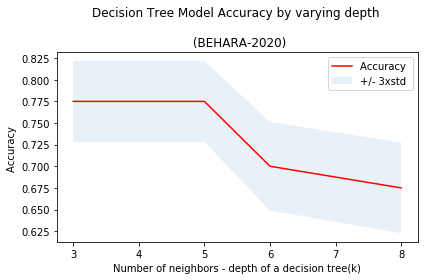

In [293]:
# Print to console the best accuracy acheived
print( "\nThe best accuracy acheived is =", accuracy_array.max(), ", with depth =", accuracy_array.argmax()+3,"\n\n") 

# Visualize the accuracy
plt.plot(range(3,k),accuracy_array,'r')
plt.fill_between(range(3,k),accuracy_array - 1 * accuracy_arraySD,accuracy_array + 1 * accuracy_arraySD, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of neighbors - depth of a decision tree(k)')
plt.title('Decision Tree Model Accuracy by varying depth \n\n (BEHARA-2020)')

plt.tight_layout()
plt.show()

### Decision Tree -  visualize the tree with classification depth of 4



 visualize the decision tree 




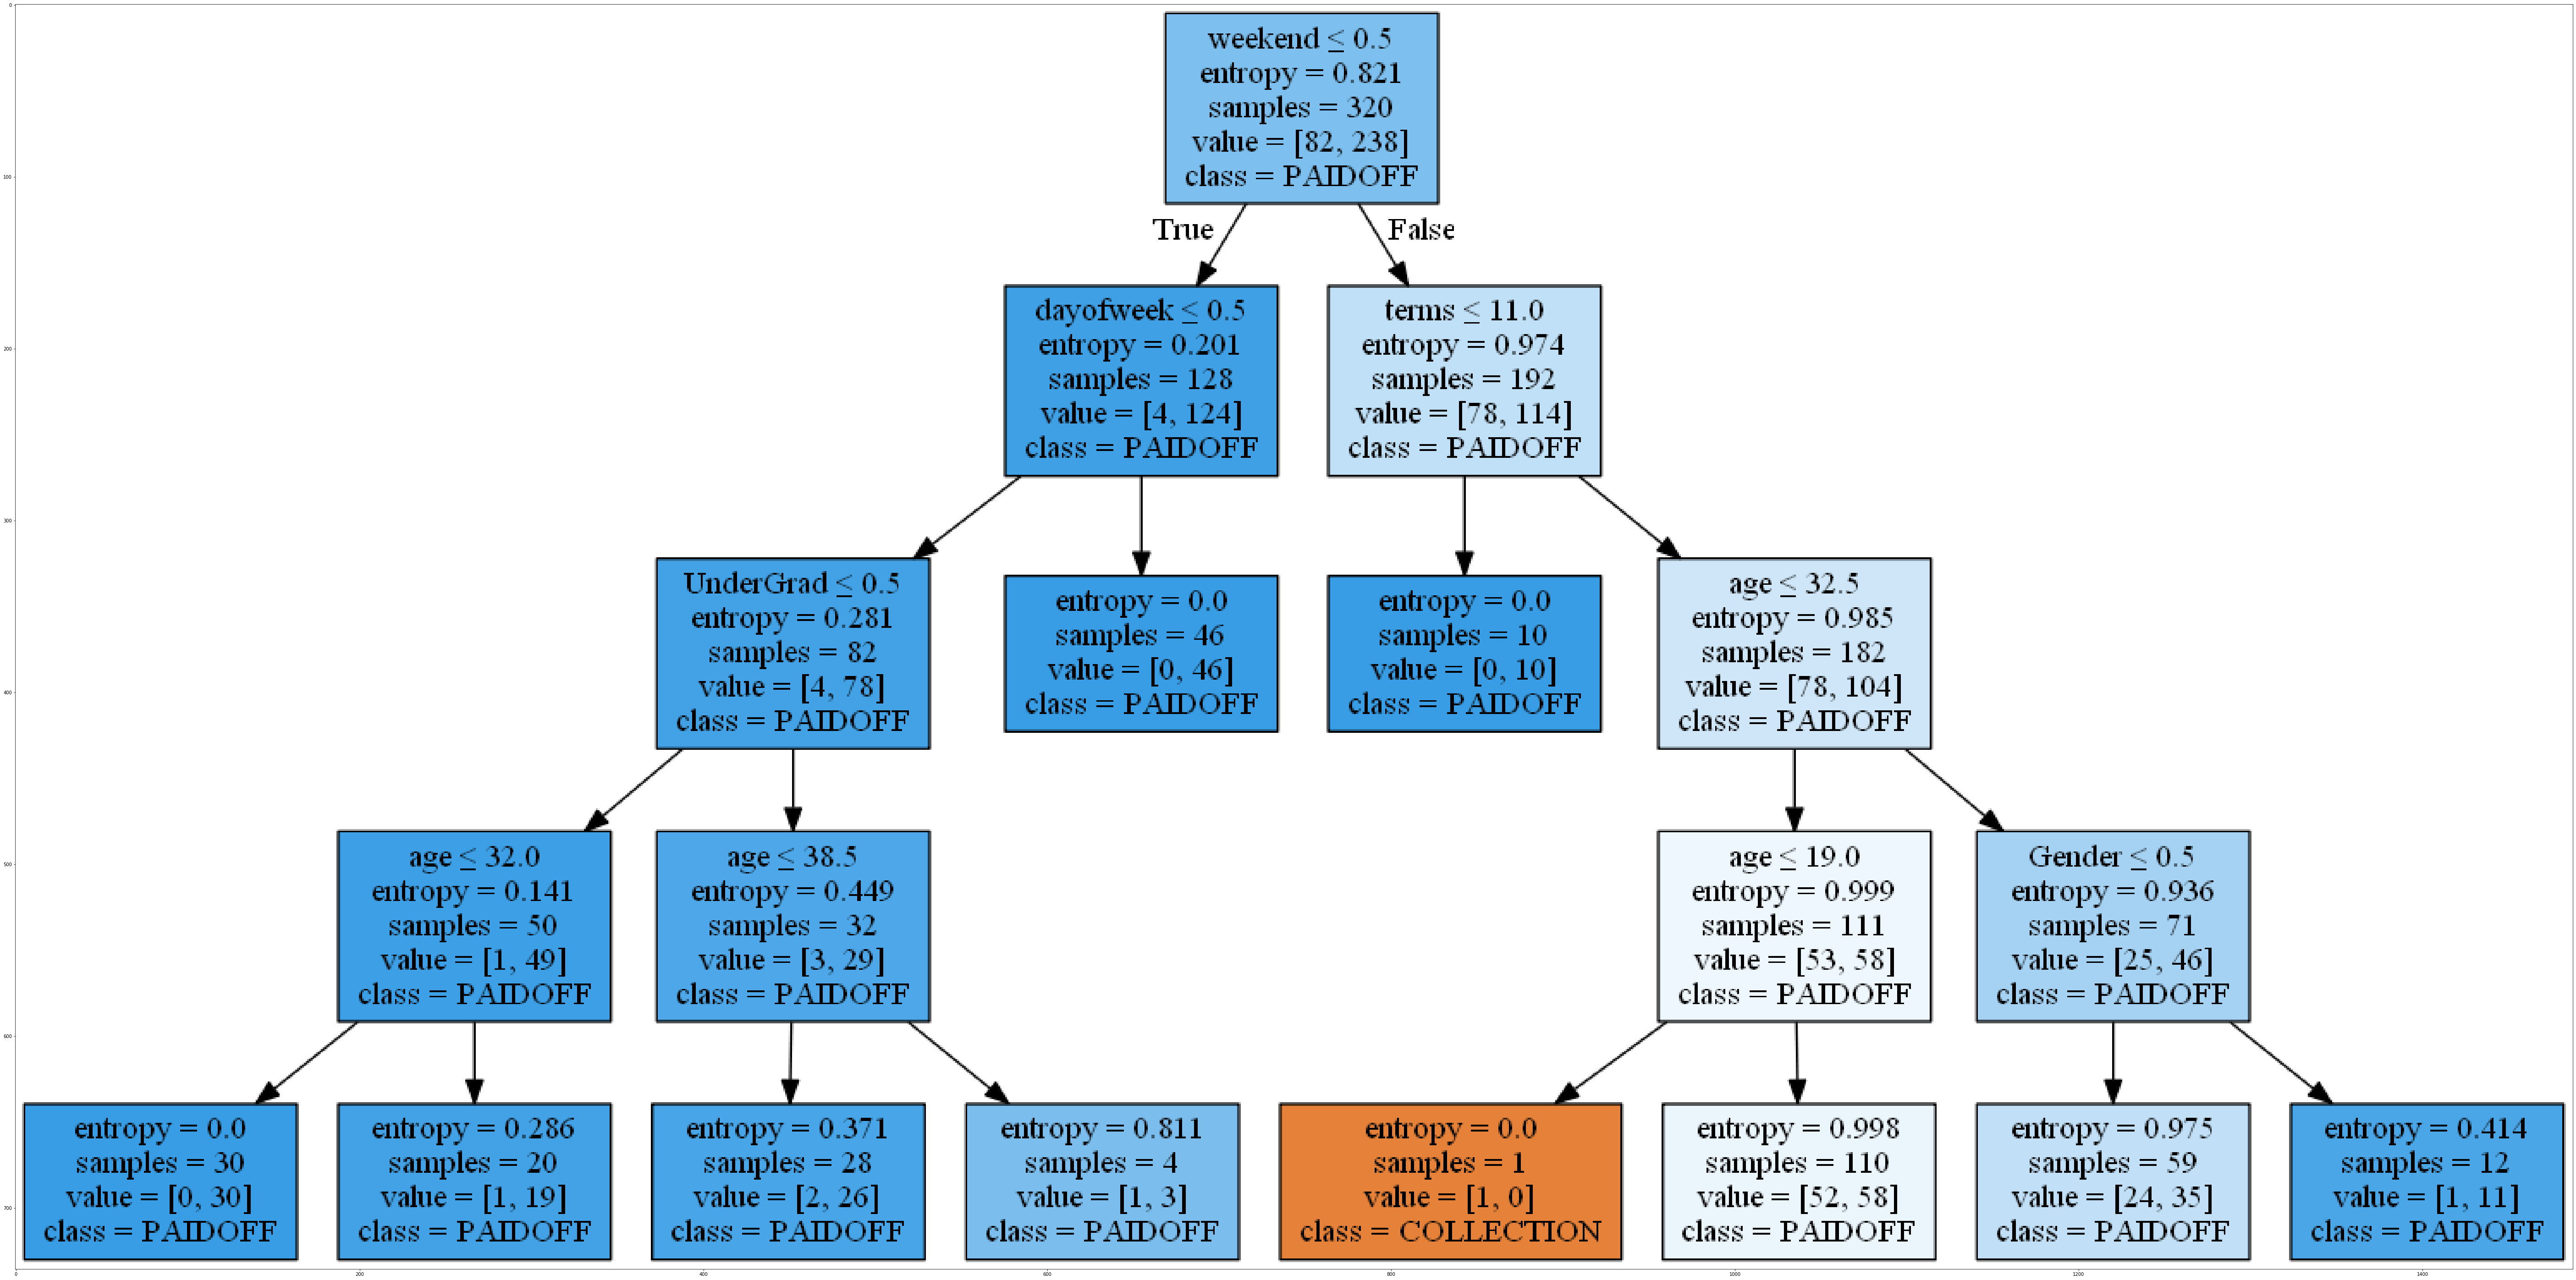

In [294]:
print("\n\n visualize the decision tree \n\n")

# Import matplotlib.pyplot & matplotlib.image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Train the Model and Predict for each value of 'n'
modelDTC = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
    
#Fit the model using the training dataset
modelDTC.fit(X_trn, Y_trn)

# Now import externals.six StringIO to plot the decision tree
from sklearn.externals.six import StringIO

# Import python Graphics Visualization Language
import pydotplus

# Import the decision tree from scikit learn 
from sklearn import tree
%matplotlib inline 

dot_data = StringIO()
filename = "decisionTree.png"
featureNames = X.columns
targetNames = Y.unique().tolist()
out=tree.export_graphviz(modelDTC,feature_names=featureNames, out_file=dot_data, class_names= np.unique(Y_trn), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

### Support Vector Machine - Build the model & make predictions

In [296]:
# Import Support Vector Machine from sklearn
from sklearn import svm

# Instantiate a classifier & use the default Radial Basis Function (RBF), a kernel method
modelSVM = svm.SVC(kernel='rbf', gamma='auto')

# Print the characteristics of the classifier (clf) model
print("\n\n The characteristics of instantiated model are :", modelSVM)

# Fit the Training data to the classifier model (Y_trn) specifies the number of classes
modelSVM.fit(X_trn, Y_trn)

print( "\n\n Classes used by the classifier are : ", clf.classes_ )

# Make the prediction
Y_svm = modelSVM.predict(X_tst)
print ("\n\n Created a prediction set using the Support Vector Machine classifier \n")




 The characteristics of instantiated model are : SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


 Classes used by the classifier are :  ['COLLECTION' 'PAIDOFF']


 Created a prediction set using the Support Vector Machine classifier 



### Support Vector Machine - Evaluate model accuracy

In [297]:
from sklearn import metrics
from sklearn.metrics import classification_report


# Compute Accuracy
print("\n\n Accuracy of the Support Vector Machine(SVM) model is: ", 
        metrics.accuracy_score(Y_tst, Y_svm))




 Accuracy of the Support Vector Machine(SVM) model is:  0.7625


### Support Vector Machine - Visualize model accuracy using Confusion Matrix 
#### Create Confusion Matrix

In [239]:
######################################################
### DEFINE A FUNCTION TO PLOT THE CONFUSION MATRIX ###
######################################################

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Display Confusion Matrix (Sensitivity  - TP Rate, Specificity  - FN Rate)

Confusion matrix, without normalization
[[57  5]
 [14  4]]


 The Accuracy score of the model is (TP + FN)/80 :  0.7625


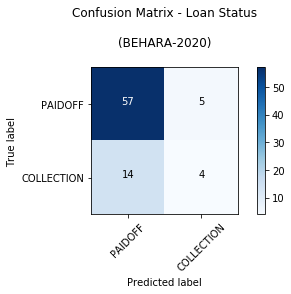

In [329]:
# Import Confusion Matrix & Classification Report from Sci-Kit Learn & Iteration tools
from sklearn.metrics import confusion_matrix
import itertools

###########################################
### COMPUTE & PLOT THE CONFUSION MATRIX ###
###########################################

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_tst, Y_svm, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()

plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF', 'COLLECTION'],normalize= False,  title='Confusion Matrix - Loan Status\n\n(BEHARA-2020)\n')

print("\n\n The Accuracy score of the model is (TP + FN)/80 : ", (cnf_matrix[0][0]+cnf_matrix[1][1])/80)

### Logistic Regression - Build the model & make predictions

In [310]:
from sklearn.linear_model import LogisticRegression

modelLOR = LogisticRegression(C=0.01, solver='liblinear').fit(X_trn,Y_trn)
print("\n\n The Logistic Regression Model Parameters are : ", modelLOR, "\n\n")

# Make predictions
Y_lor = modelLOR.predict(X_tst)
print("\n\n First few of the predictictions are : ", Y_lor[:5], "\n\n")




 The Logistic Regression Model Parameters are :  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) 




 First few of the predictictions are :  ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'] 




### Logistic Regression - Evaluate model accuracy

In [309]:
# Compute Accuracy
print("\n\n Accuracy of the Logistic Regression Model is: ", 
        metrics.accuracy_score(Y_tst, Y_lor))




 Accuracy of the Logistic Regression Model is:  0.7625


### Logistic Regression - Visualize model accuracy using Confusion Matrix

Confusion matrix, without normalization
[[61  1]
 [18  0]]


 The Accuracy score of the model is (TP + FN)/80 :  0.7625


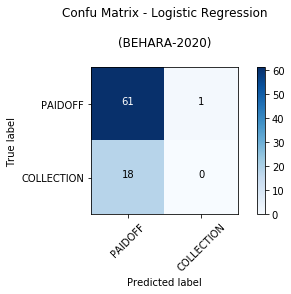

In [313]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_tst, Y_lor, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confu Matrix - Logistic Regression\n\n(BEHARA-2020)\n')

print("\n\n The Accuracy score of the model is (TP + FN)/80 : ", (cnf_matrix[0][0]+cnf_matrix[1][1])/80)

## Model Accuracy 
### KNN, DECISION TREE, SVM, LOGISTIC REGRESSION

#### F1 Score for each model

In [317]:
print("\n\n Classification Report of the K Nearest Neighbors (KNN)   \n-------------------------------------------------------\n ", 
       classification_report(Y_tst, Y_knn))

print("\n\n Classification Report of the Decision Tree Classifier    \n------------------------------------------------------\n ", 
       classification_report(Y_tst, Y_dtr))


print("\n\n Classification Report of the Support Vector Machine (SVM) \n----------------------------------------------------------\n ", 
       classification_report(Y_tst, Y_svm))

print("\n\n Classification Report of the Logistic Regression Model    \n----------------------------------------------------------\n ", 
       classification_report(Y_tst, Y_lor))



 Classification Report of the K Nearest Neighbors (KNN)   
-------------------------------------------------------
                precision    recall  f1-score   support

  COLLECTION       0.29      0.28      0.29        18
     PAIDOFF       0.79      0.81      0.80        62

    accuracy                           0.69        80
   macro avg       0.54      0.54      0.54        80
weighted avg       0.68      0.69      0.68        80



 Classification Report of the Decision Tree Classifier    
------------------------------------------------------
                precision    recall  f1-score   support

  COLLECTION       0.38      0.67      0.48        18
     PAIDOFF       0.88      0.68      0.76        62

    accuracy                           0.68        80
   macro avg       0.62      0.67      0.62        80
weighted avg       0.76      0.68      0.70        80



 Classification Report of the Support Vector Machine (SVM) 
-----------------------------------------------

#### Jaccard Similarity Score for each model

In [325]:
from sklearn.metrics import jaccard_similarity_score

print("\n Jaccard Similarity Score - K Nearest Neighbors (KNN)     : ", jaccard_similarity_score(Y_tst, Y_knn))
print("\n Jaccard Similarity Score - Decision Tree Classifier      : ", jaccard_similarity_score(Y_tst, Y_dtr))
print("\n Jaccard Similarity Score - Support Vector Machine (SVM)  : ", jaccard_similarity_score(Y_tst, Y_svm))
print("\n Jaccard Similarity Score - Logistic Regression Model     : ", jaccard_similarity_score(Y_tst, Y_lor))



 Jaccard Similarity Score - K Nearest Neighbors (KNN)     :  0.6875

 Jaccard Similarity Score - Decision Tree Classifier      :  0.675

 Jaccard Similarity Score - Support Vector Machine (SVM)  :  0.7625

 Jaccard Similarity Score - Logistic Regression Model     :  0.7625


C:\Users\rahdi\Apps\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
C:\Users\rahdi\Apps\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
C:\Users\rahdi\Apps\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surpr

#### Logarithmic loss of Logistic Regression (approximation)

In [327]:
from sklearn.metrics import log_loss

#Predict Probability of the Loan Status classes, ['PAIDOFF', 'COLLECTION']
Y_lor_prob = modelLOR.predict_proba(X_tst)
print("\n\n First Few values of the probabilities are : ",Y_lor_prob[:5])
print("\n\n Logarithmic loss (LogLoss) of the Logistic Regression model is : ", log_loss(Y_tst, Y_lor_prob))



 First Few values of the probabilities are :  [[0.03 0.97]
 [0.29 0.71]
 [0.27 0.73]
 [0.35 0.65]
 [0.5  0.5 ]]


 Logarithmic loss (LogLoss) of the Logistic Regression model is :  0.45254317951648504
